<a href="https://colab.research.google.com/github/LuluW8071/ASR-with-Speech-Sentiment-and-Text-Summarizer/blob/main/ASR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ASR Dataset EDA

## 0. Download Subset of Data

In [1]:
!gdown "https://drive.google.com/uc?id=1rHenEIWb10HqrCp1NQ9fyRWAYlF_er2H"
!mkdir -p dataset
!unzip speech_sample.zip -d dataset/ > /dev/null 2>&1

Downloading...
From (original): https://drive.google.com/uc?id=1rHenEIWb10HqrCp1NQ9fyRWAYlF_er2H
From (redirected): https://drive.google.com/uc?id=1rHenEIWb10HqrCp1NQ9fyRWAYlF_er2H&confirm=t&uuid=6f640644-aebd-47b3-b161-b043d54fec25
To: /content/speech_sample.zip
100% 83.1M/83.1M [00:03<00:00, 25.5MB/s]


## 1. Import necessary libraries

In [29]:
import json
import librosa
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt

from IPython.display import Audio

## 2. Basic EDA

In [18]:
# Load the audio clips path and sentences from test.json
json_path = "dataset/converted_clips/test.json"
with open(json_path, 'r') as f:
    data = json.load(f)

audio_files = data[0:5]
audio_files

[{'key': 'dataset/converted_clips/clips/common_voice_en_39747708.flac',
  'text': 'The original mansion was destroyed in the French Revolution'},
 {'key': 'dataset/converted_clips/clips/common_voice_en_39749320.flac',
  'text': 'The port has grainhandling and some warehousing facilities'},
 {'key': 'dataset/converted_clips/clips/common_voice_en_40058417.flac',
  'text': 'After the incident she took a break from Twitter'},
 {'key': 'dataset/converted_clips/clips/common_voice_en_39792185.flac',
  'text': 'Cinchona trees remain the only economically practical source of quinine'},
 {'key': 'dataset/converted_clips/clips/common_voice_en_39639939.flac',
  'text': 'He studied Sociology and Journalism at university'}]

Sample Rate of dataset/converted_clips/clips/common_voice_en_39747708.flac: 16000


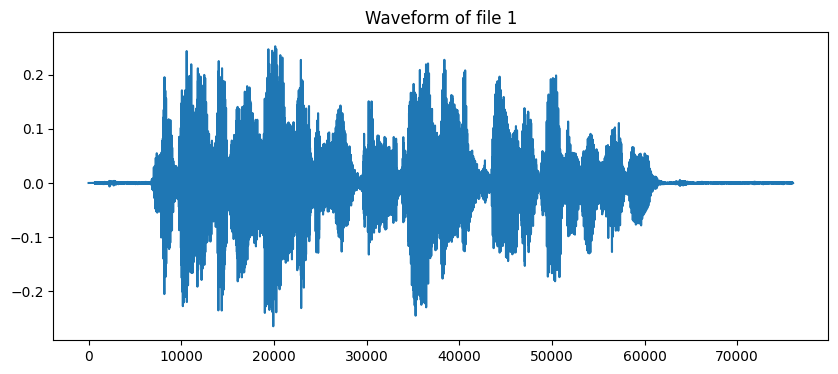



Sample Rate of dataset/converted_clips/clips/common_voice_en_39749320.flac: 16000


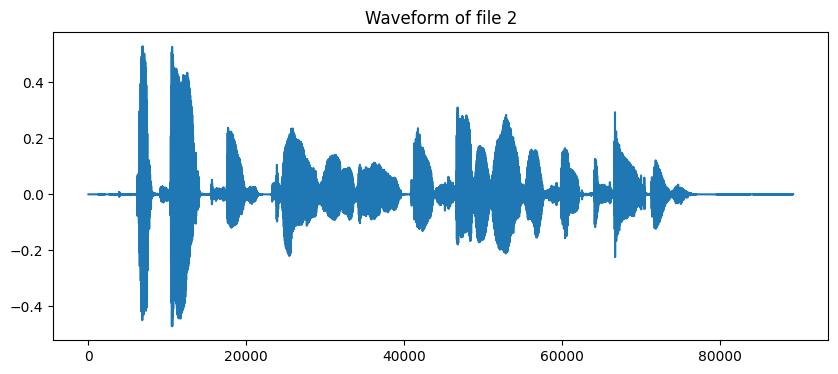



Sample Rate of dataset/converted_clips/clips/common_voice_en_40058417.flac: 16000


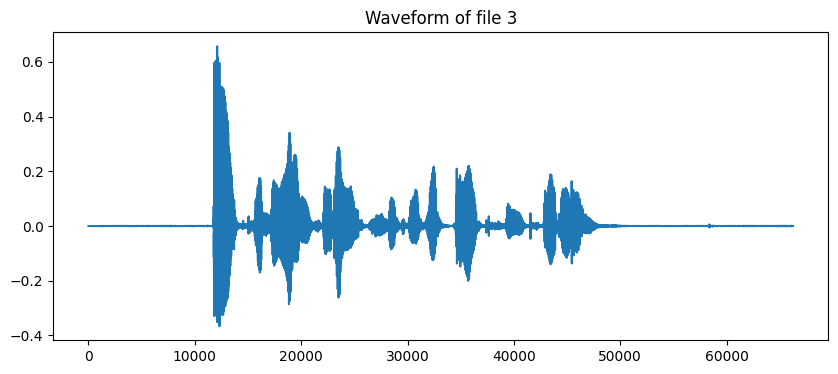



Sample Rate of dataset/converted_clips/clips/common_voice_en_39792185.flac: 16000


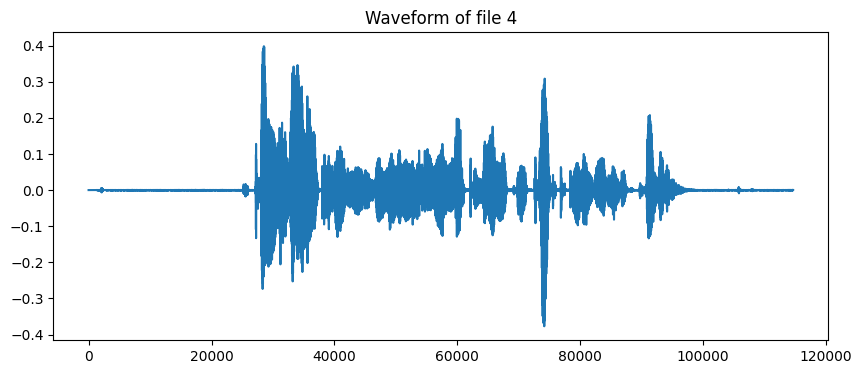



Sample Rate of dataset/converted_clips/clips/common_voice_en_39639939.flac: 16000


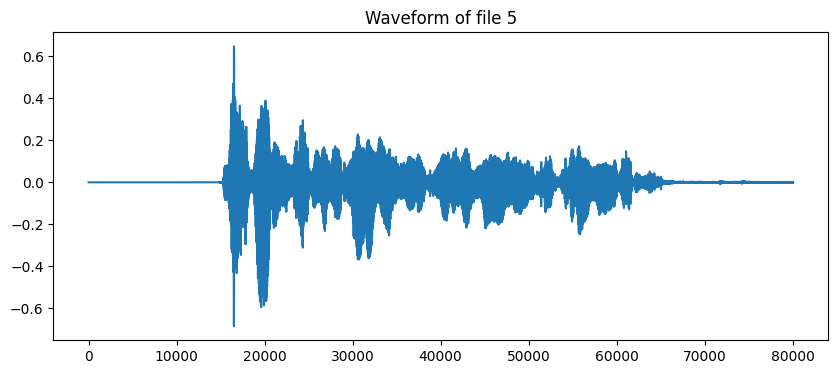

In [21]:
# Load the sample audio file
for idx, audio_info in enumerate(audio_files):
    audio_path = audio_info['key']

    # Load the sample audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    print(f"Sample Rate of {audio_path}: {sample_rate}")

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(waveform.t().numpy())
    plt.title(f"Waveform of file {idx+1}")
    plt.show()

    # Play the audio
    display(Audio(audio_path))
    print("\n")

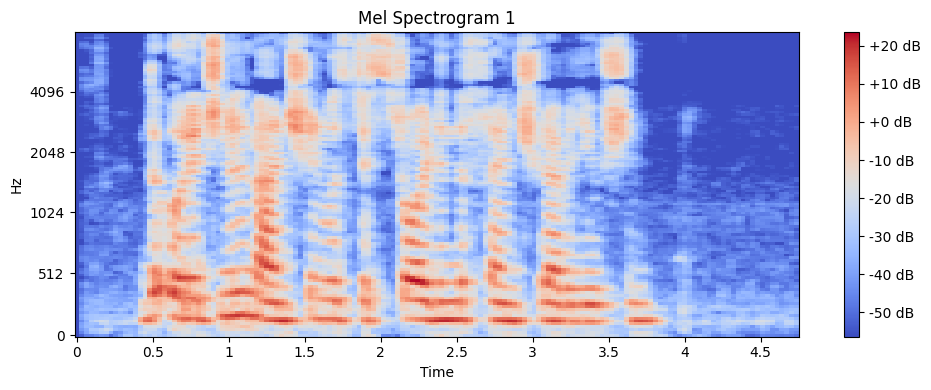

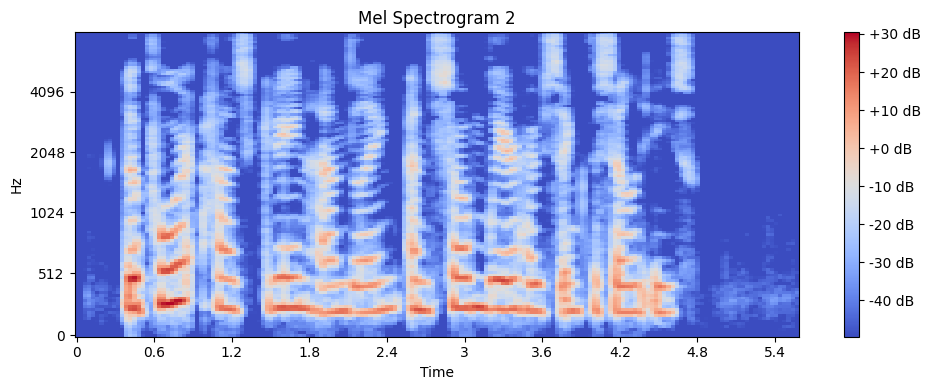

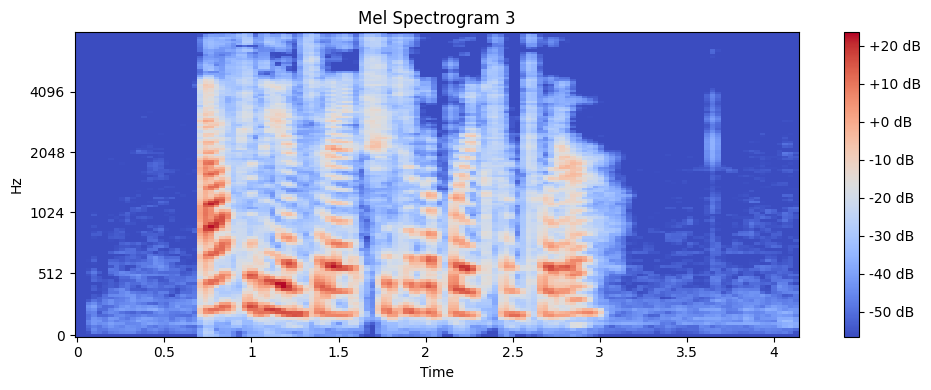

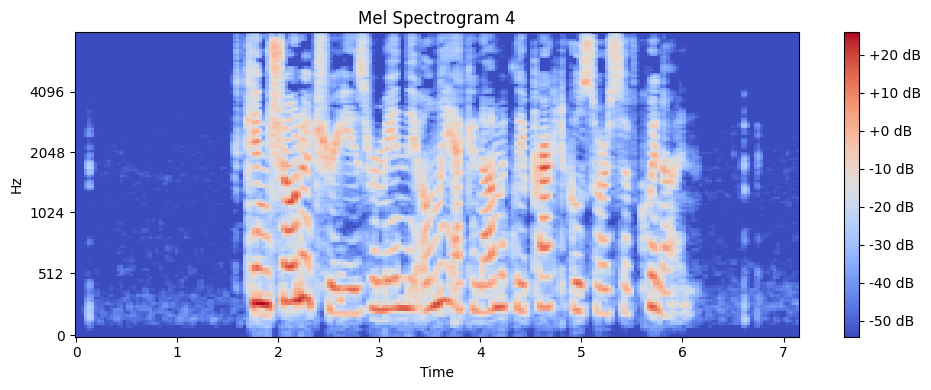

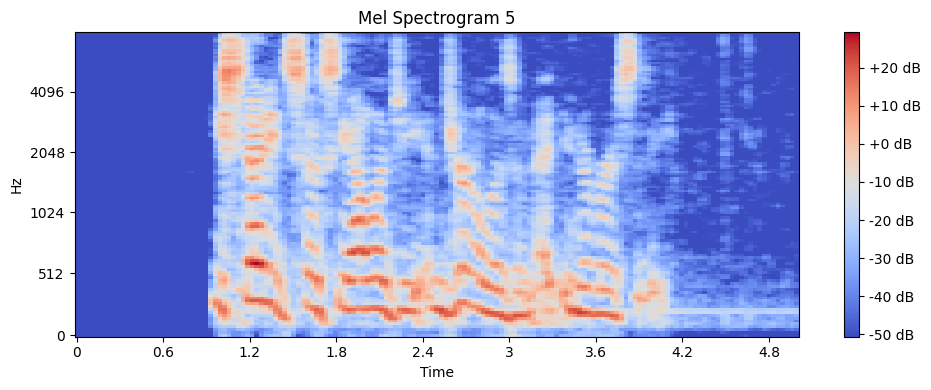

In [35]:
for idx, audio_info in enumerate(audio_files):
    audio_path = audio_info['key']
    waveform, sample_rate = torchaudio.load(audio_path)
    waveform_np = waveform.numpy().flatten()

    # Mel spectrogram
    spectrogram = librosa.feature.melspectrogram(y=waveform_np, sr=sample_rate, n_mels=128, fmax=sample_rate/2)
    log_spectrogram = librosa.power_to_db(spectrogram)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.title(f'Mel Spectrogram {idx+1}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

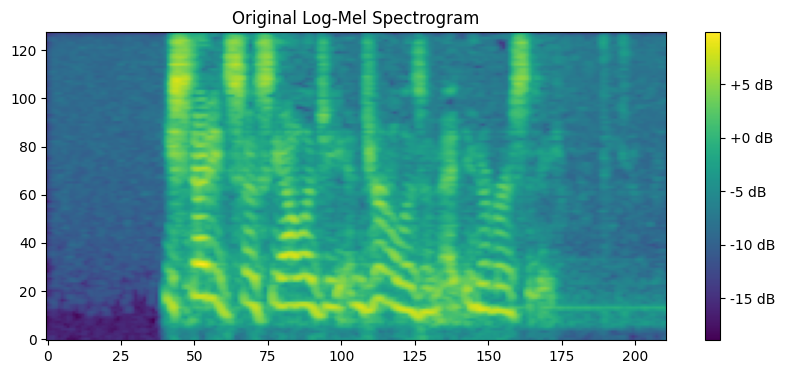

In [22]:
# Defining LogMelSpec transformation
log_mel_spec_transform = transforms.MelSpectrogram(
    sample_rate=16000,
    n_mels=128,
    hop_length=380,
    n_fft = 1024*2
)

# Compute the log-mel spectrogram
log_mel_spec = log_mel_spec_transform(waveform)
log_mel_spec = torch.log(log_mel_spec + 1e-14)  # Avoid log(0)

# Display the original spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(log_mel_spec.squeeze(0).numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title("Original Log-Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

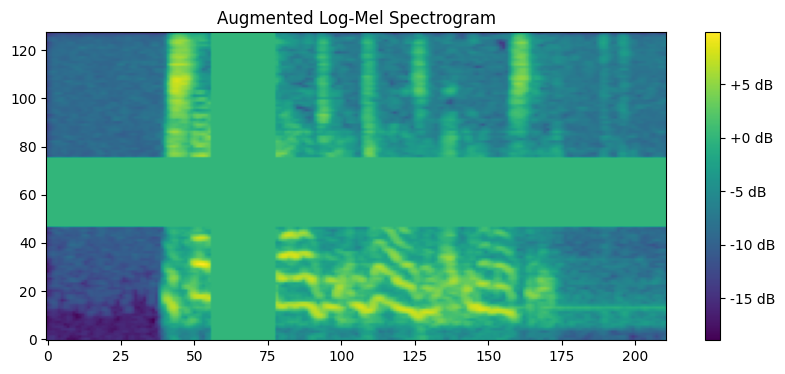

In [25]:
# SpecAugment transformations
spec_augment = nn.Sequential(
                transforms.FrequencyMasking(freq_mask_param=30),
                transforms.TimeMasking(time_mask_param=70)
)

# Applying SpecAugment
augmented_log_mel_spec = spec_augment(log_mel_spec)

# Display augmented spectrogram
plt.figure(figsize=(10, 4))
plt.imshow(augmented_log_mel_spec.squeeze(0).numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.title("Augmented Log-Mel Spectrogram")
plt.colorbar(format='%+2.0f dB')
plt.show()

In [28]:
log_mel_spec.squeeze(0).numpy(), log_mel_spec.squeeze(0).shape

(array([[-15.620027 , -14.730217 , -14.5791855, ..., -11.006966 ,
          -9.237769 ,  -8.428447 ],
        [-15.867311 , -14.877195 , -14.643786 , ..., -11.087782 ,
         -10.013955 ,  -9.111862 ],
        [-16.22989  , -16.061264 , -15.94692  , ..., -10.464956 ,
         -10.3363085,  -9.586719 ],
        ...,
        [-11.650034 , -10.106531 ,  -9.481733 , ...,  -7.5443926,
          -7.1598043,  -7.400547 ],
        [-13.435461 , -12.280023 , -11.691729 , ...,  -8.932588 ,
          -8.468962 ,  -8.520858 ],
        [-14.63223  , -13.800301 , -13.120451 , ..., -12.281774 ,
         -12.584503 , -11.775344 ]], dtype=float32),
 torch.Size([128, 211]))

In [27]:
augmented_log_mel_spec.squeeze(0).numpy(), augmented_log_mel_spec.squeeze(0).numpy().shape

(array([[-15.620027 , -14.730217 , -14.5791855, ..., -11.006966 ,
          -9.237769 ,  -8.428447 ],
        [-15.867311 , -14.877195 , -14.643786 , ..., -11.087782 ,
         -10.013955 ,  -9.111862 ],
        [-16.22989  , -16.061264 , -15.94692  , ..., -10.464956 ,
         -10.3363085,  -9.586719 ],
        ...,
        [-11.650034 , -10.106531 ,  -9.481733 , ...,  -7.5443926,
          -7.1598043,  -7.400547 ],
        [-13.435461 , -12.280023 , -11.691729 , ...,  -8.932588 ,
          -8.468962 ,  -8.520858 ],
        [-14.63223  , -13.800301 , -13.120451 , ..., -12.281774 ,
         -12.584503 , -11.775344 ]], dtype=float32),
 (128, 211))